In [ ]:
from google.colab import drive

drive.mount('./gdrive', force_remount=True)
%cd './gdrive/My Drive/Colab Notebooks/cubricks'

In [ ]:
!pip -q install imbalanced-learn --upgrade

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import InstanceHardnessThreshold, RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

seed = 42

In [ ]:
def plot_data_distribution(train, test):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 2))
    sns.countplot(np.squeeze(train), ax=ax[0]).set_title(f'Train - {col}')
    sns.countplot(np.squeeze(test), ax=ax[1]).set_title(f'Test - {col}')


def plot_confuncion_matrix(y_test, predict, title='Confuncion Matrix'):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    sns.heatmap(confusion_matrix(y_test, predict), fmt='d', square=True, annot=True, cmap='Blues', ax=ax).set_title(title)


def split_data_month_window(df, col, date, month_window):
    date_0 = pd.to_datetime(date)
    date_1 = date_0 - pd.DateOffset(months=month_window)
    date_2 = date_0 + pd.DateOffset(months=1)
    train = df[(df[col] >= date_1) & (df[col] < date_0)]
    test = df[(df[col] >= date_0) & (df[col] < date_2)]
    return train, test


def resample(df, x_column, y_column, func):
    dtypes = df[x_column].dtypes.to_dict()
    dtypes.update(df[y_column].dtypes.to_dict())

    x, y = df[x_column].values, df[y_column].values
    x, y = func.fit_resample(x, y)
    xy = np.concatenate((x, np.expand_dims(y, axis=1)), axis=1)
    
    data = pd.DataFrame(xy, columns=np.concatenate((x_column, y_column)))
    data = data.astype(dtypes)
    return data


def features_selection(train, test, x_column, y_column):
    cb, predicts = [], []

    for y in range(len(x_column)):
        for x in range(y, len(x_column)):
            cb.append(cb[-1] + [x_column[x]] if x > y else [x_column[y]])

    cb = np.array(sorted(cb, key=len))
    print(f'Combinations: {len(cb)}')

    for features_comb in cb:
        clf = RandomForestClassifier(n_estimators=40, criterion='entropy', min_weight_fraction_leaf=1e-4, random_state=seed)

        x_train, y_train = train[features_comb].values, train[y_column].values
        x_test, y_test = test[features_comb].values, test[y_column].values

        clf.fit(x_train, np.squeeze(y_train))
        predict = clf.predict(x_test)

        cr = classification_report(y_test, predict, output_dict=True, zero_division=True)
        predicts.append([cr['macro avg']['f1-score'], features_comb])

    predicts = np.array(predicts, dtype=object)
    argmax_index = np.argmax(predicts[:,0])
    return (predicts, argmax_index)

In [ ]:
df = pd.read_csv('InvoicedDocuments_v4.csv', sep=';', na_values=['N/I'])

df.dropna(subset=['ClearingDate'], inplace=True)
df.fillna(0, inplace=True)


number_cols = ['CustomerRegion', 'PaymentTerms']
df[number_cols] = df[number_cols].apply(lambda x: [int(y) if str(y).isnumeric()else int(''.join(format(ord(w), '') for w in str(y))) for y in x])


int_cols = ['InvoicedDocuments', 'PaidDocuments', 'PaidPastDocuments', 'OpenDocuments', 'PastDueDocuments']
df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')


date_cols = ['CustomerLastCreditReview', 'DocumentDate', 'DueDate', 'ClearingDate']
df[date_cols] = df[date_cols].apply(pd.to_datetime, errors='coerce')

for col in date_cols[1:]:
    df[col + 'Month'] = pd.DatetimeIndex(df[col]).month
    df[col + 'Day'] = pd.DatetimeIndex(df[col]).day
    df[col + 'WeekDay'] = pd.DatetimeIndex(df[col]).weekday
    df[col + 'MonthEnd'] = df[col] + pd.offsets.MonthEnd(1)


dividend_cols = ['InvoicedAmount', 'PaidAmount', 'PaidPastAmount', 'OpenAmount', 'PastDueAmount']
divisor_cols = ['InvoicedDocuments', 'PaidDocuments', 'PaidPastDocuments', 'OpenDocuments', 'PastDueDocuments']

for dividend, divisor in zip(dividend_cols, divisor_cols):
    ratio_col = 'Ratio' + dividend + divisor
    df[ratio_col] = df[dividend] / df[divisor]
    df[ratio_col].fillna(0, inplace=True)


source_cols = ['DocumentDate', 'DocumentDate', 'DueDate', 'DocumentDate', 'CustomerLastCreditReview']
target_cols = ['DueDate', 'DueDateMonthEnd', 'DueDateMonthEnd', 'ClearingDate', 'DocumentDate']

for src, tgt in zip(source_cols, target_cols):
    delta_col = 'DaysTo' + tgt
    df[delta_col] = df[tgt] - df[src]
    df[delta_col].fillna(pd.Timedelta(seconds=0), inplace=True)
    df[delta_col] = df[delta_col].astype('timedelta64[D]').astype(int)
    df[delta_col] = df[delta_col].clip(lower=0)


df.sort_values(by=['DocumentDate'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
df = df[df['DocumentDate'] < df['DueDate']]
df = df[df['DocumentDate'] < df['ClearingDate']]

df = df[(df['ClearingDate'].dt.month - df['DueDate'].dt.month) >= 0]
# df = df[(df['ClearingDate'].dt.month - df['DueDate'].dt.month) <= 1]

df['AfterDueDateMonthEnd'] = (df['ClearingDate'] > df['DueDateMonthEnd']) * 1
df.groupby(['AfterDueDateMonthEnd'])['AfterDueDateMonthEnd'].count()

AfterDueDateMonthEnd
0    2061777
1     112853
Name: AfterDueDateMonthEnd, dtype: int64

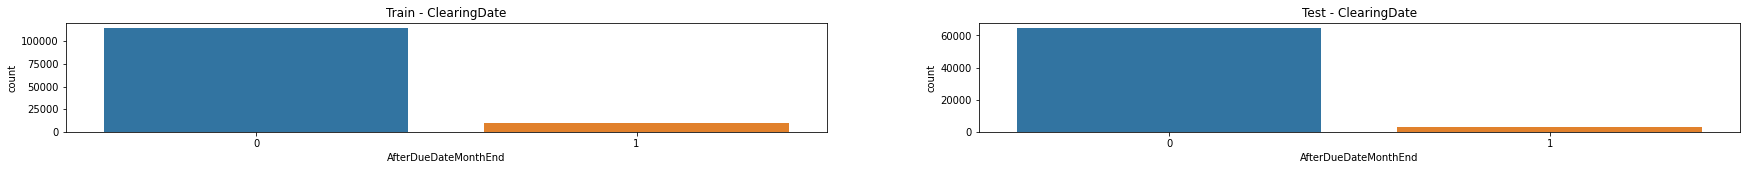

In [ ]:
y_column = np.array(['AfterDueDateMonthEnd'])
x_column = np.array([
                     'CompanyKey',
                     'CustomerKey',
                     'CustomerRegion',
                     'PaymentTerms',
                     'DocumentDateDay',
                     'DocumentDateMonth',
                     'DocumentDateWeekDay',
                     'DueDateDay',
                     'DueDateMonth',
                     'DueDateWeekDay',
                     'DaysToDocumentDate',
                     'DaysToDueDate',
                     'DaysToDueDateMonthEnd',
                     'AvgDSOPastDueDocuments',
                     'DocumentAmount',
                     'InvoicedAmount',
                     'InvoicedDocuments',
                     'OpenAmount',
                     'OpenDocuments',
                     'PaidAmount',
                     'PaidDocuments',
                     'PaidPastAmount',
                     'PaidPastDocuments',
                     'PastDueAmount',
                     'PastDueDays',
                     'PastDueDocuments',
                     'RatioInvoicedAmountInvoicedDocuments',
                     'RatioOpenAmountOpenDocuments',
                     'RatioPaidAmountPaidDocuments',
                     'RatioPaidPastAmountPaidPastDocuments',
                     'RatioPastDueAmountPastDueDocuments',
                     ])

# x_column = np.array([
#                      'CompanyKey',
#                      'CustomerKey',
#                      'CustomerRegion',
#                      'PaymentTerms',
#                      'DocumentDateDay',
#                      'DocumentDateMonth',
#                      'DocumentDateWeekDay',
#                      'DueDateDay',
#                      'DueDateMonth',
#                      'DueDateWeekDay',
#                      'DaysToDocumentDate',
#                      'DaysToDueDate',
#                      'DaysToDueDateMonthEnd',
#                      'AvgDSOPastDueDocuments',
#                      'DocumentAmount',
#                      'InvoicedAmount',
#                      'InvoicedDocuments',
#                      ])


train, test = split_data_month_window(df, col='DocumentDate', date='2020-06-01', month_window=2)

plot_data_distribution(train[y_column], test[y_column])

>>> Dummy prediction <<<
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     64465
           1       0.04      1.00      0.08      2896

    accuracy                           0.04     67361
   macro avg       0.52      0.50      0.04     67361
weighted avg       0.96      0.04      0.00     67361



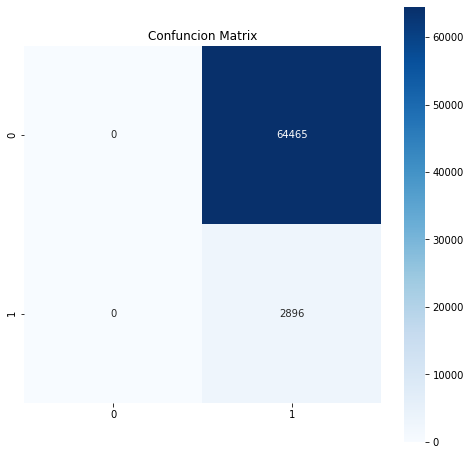

In [ ]:
x_test, y_test = np.ones(test[y_column].values.shape), test[y_column].values

print('>>> Dummy prediction <<<')
print(classification_report(y_test, x_test, zero_division=True))

plot_confuncion_matrix(y_test, x_test)

>>> Imbalanced model prediction <<<
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     64465
           1       0.55      0.40      0.46      2896

    accuracy                           0.96     67361
   macro avg       0.76      0.69      0.72     67361
weighted avg       0.96      0.96      0.96     67361



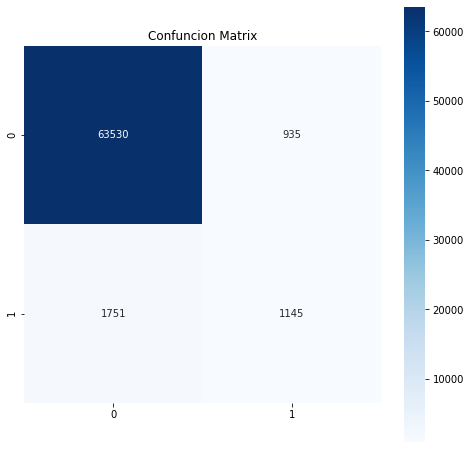

In [ ]:
x_train, y_train = train[x_column].values, train[y_column].values
x_test, y_test = test[x_column].values, test[y_column].values

clf = RandomForestClassifier(n_estimators=40, criterion='entropy', min_weight_fraction_leaf=1e-4, random_state=seed)
clf.fit(x_train, np.squeeze(y_train))

predict = clf.predict(x_test)

print('>>> Imbalanced model prediction <<<')
print(classification_report(y_test, predict))

plot_confuncion_matrix(y_test, predict)

In [ ]:
from imblearn.under_sampling import CondensedNearestNeighbour, InstanceHardnessThreshold, NearMiss, NeighbourhoodCleaningRule, OneSidedSelection, RandomUnderSampler, TomekLinks
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, KMeansSMOTE, RandomOverSampler, SMOTE, SMOTENC, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

categorical_features_mask = [True for _ in range(12)] + [False for _ in range(18)]
train_res = resample(train, x_column, y_column, SMOTENC(categorical_features_mask, sampling_strategy=0.1, k_neighbors=100, random_state=seed))

# train_res = resample(train, x_column, y_column, ADASYN(sampling_strategy=0.75, n_neighbors=500, random_state=seed))


# train_res = resample(train, x_column, y_column, ADASYN(sampling_strategy=1.0, n_neighbors=1000, random_state=seed))

# train_res = resample(train, x_column, y_column, RandomUnderSampler(replacement=True, random_state=seed))

# train_res = resample(train, x_column, y_column, InstanceHardnessThreshold(random_state=seed, n_jobs=-1))
# train_res = resample(train_res, x_column, y_column, ADASYN(sampling_strategy=0.75, n_neighbors=500, random_state=seed))
# train_res = resample(train_res, x_column, y_column, RandomUnderSampler(replacement=True, random_state=seed))

plot_data_distribution(train_res[y_column], test[y_column])

>>> Imbalanced model prediction <<<
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     67063
           1       0.28      0.12      0.17      3125

    accuracy                           0.95     70188
   macro avg       0.62      0.55      0.57     70188
weighted avg       0.93      0.95      0.94     70188



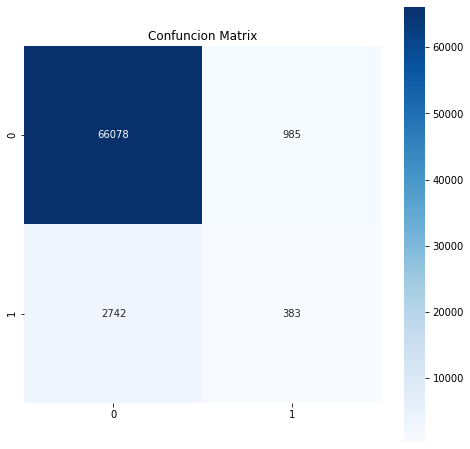

In [ ]:
x_train, y_train = train_res[x_column].values, train_res[y_column].values
x_test, y_test = test[x_column].values, test[y_column].values

clf = RandomForestClassifier(n_estimators=40, criterion='entropy', min_weight_fraction_leaf=1e-4, random_state=seed)
clf.fit(x_train, np.squeeze(y_train))

predict = clf.predict(x_test)

print('>>> Imbalanced model prediction <<<')
print(classification_report(y_test, predict))

plot_confuncion_matrix(y_test, predict)

In [ ]:
# predicts, argmax_index = features_selection(train, test, x_column, y_column)

# print(f'>>> Max f1-score: {predicts[argmax_index]}\n>>> Attempts:\n{predicts}')
# print(np.array(sorted(predicts[:,0])))

In [ ]:
# train_res = resample(train, x_column, y_column, AllKNN(random_state=seed))
# train_res = resample(train, x_column, y_column, RepeatedEditedNearestNeighbours())

# train_res = resample(train, x_column, y_column, InstanceHardnessThreshold(random_state=seed, n_jobs=-1))
# train_res = resample(train_res, x_column, y_column, ADASYN(sampling_strategy=0.75, n_neighbors=500, random_state=seed))
# train_res = resample(train_res, x_column, y_column, RandomUnderSampler(replacement=True, random_state=seed))

# plot_data_distribution(train_res[y_column], test[y_column])

In [ ]:
# x_train, y_train = train[x_column].values, train[y_column].values
# x_test, y_test = test[x_column].values, test[y_column].values

# clf = RandomForestClassifier(n_estimators=40, criterion='entropy', min_weight_fraction_leaf=1e-4, random_state=seed)
# clf.fit(x_train, np.squeeze(y_train))

# predict = clf.predict(x_test)

# print('>>> Balanced model prediction <<<')
# print(classification_report(y_test, predict))

# plot_confuncion_matrix(y_test, predict)

In [ ]:
# from sklearn.model_selection import train_test_split
# import tensorflow as tf

# # !nvidia-smi
# # !pip install -q tensorflow-gpu


# def binary_encoding(df, cols):
#     for col in cols:
#         bincol = np.array([str('{0:b}'.format(x)) for x in df[col[1]].values])
#         header = np.array([f'{col[1]}{i}' for i in range(col[0])])
#         newcol = np.zeros((bincol.shape[0], col[0]), dtype=np.int8)

#         for i in range(bincol.shape[0]):
#             a = np.array(list(bincol[i]), dtype=np.int8)
#             newcol[i][col[0] - len(a):] = a

#         df2 = pd.DataFrame(newcol, columns=header)
#         df.reset_index(drop=True, inplace=True)
#         df = pd.concat([df, df2], axis=1)
#         df.drop(columns=[col[1]], inplace=True)

#     return df


# train_nn = train_res[x_column].copy()
# test_nn = test[x_column].copy()

# cols = [(32, 'CompanyKey'),
#         (32, 'CustomerKey'),
#         (32, 'CustomerRegion'),
#         (32, 'PaymentTerms'),
#         (3, 'DocumentDateWeekDay'),
#         (3, 'DueDateWeekDay')]

# train_nn = binary_encoding(train_nn, cols)
# test_nn = binary_encoding(test_nn, cols)


# x_train, x_valid, y_train, y_valid = train_test_split(train_nn.values, train_res[y_column].values,
#                                                       test_size=0.1, shuffle=True, random_state=seed,
#                                                       stratify=train_res[y_column].values)

# y_train_categorical = tf.keras.utils.to_categorical(y_train)
# y_valid_categorical = tf.keras.utils.to_categorical(y_valid)



# def create_model():
#     model = tf.keras.models.Sequential(name='cubricks')

#     model.add(tf.keras.layers.Input(shape=train_nn.values.shape[1]))
#     model.add(tf.keras.layers.BatchNormalization(renorm=True))

#     model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
#     model.add(tf.keras.layers.BatchNormalization(renorm=True))
#     model.add(tf.keras.layers.Dropout(rate=0.1))

#     model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
#     model.add(tf.keras.layers.BatchNormalization(renorm=True))
#     model.add(tf.keras.layers.Dropout(rate=0.1))

#     model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
#     model.add(tf.keras.layers.BatchNormalization(renorm=True))
#     model.add(tf.keras.layers.Dropout(rate=0.1))

#     model.add(tf.keras.layers.Dense(2, activation='softmax'))
#     return model


# model = create_model()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8, amsgrad=True),
#               loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1, reduction=tf.keras.losses.Reduction.SUM),
#               metrics=['accuracy'])

# model.summary()
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-8, patience=20, restore_best_weights=True, verbose=1)]

# model.fit(x_train,
#           y_train_categorical,
#           validation_data=(x_valid, y_valid_categorical),
#           callbacks=callbacks,
#           batch_size=256,
#           epochs=10000,
#           verbose=1)

# predict = np.argmax(model.predict(test_nn.values), axis=1)

# print('\nNeural network model prediction:')
# _ = accuracy_by_class(y_test, predict)